In [2]:
import numpy as np
import matplotlib.pyplot as plt

# BayesWave Prior

The BayesWave prior on SNR is peaked at a particular value SNR${}_\ast$, and decays linearly to zero for low SNR, and as SNR${}^{-4}$ for high SNR, consistent with a volumetric distance prior.

Assuming SNR $\sim 1/d_L$, we obtain an equivalent prior on distance,

$$
p(d_L) \sim \frac{d_L^2}{(2d_L/(3d_{L\ast}) + 1)^5}
$$

To sample from this prior, we require the inverse CDF. This is somewhat complicated to calculate because it requires solving a quartic equation.

In [3]:
# Unnormalized probability density

def ptilde(d, dstar):
    return d**2 / (2*d/(3*dstar) + 1)**5

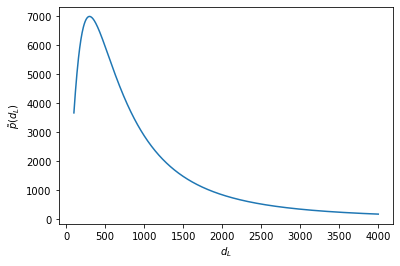

In [4]:
x = np.linspace(100,4000,1000)
plt.plot(x, ptilde(x, 300))
plt.xlabel('$d_L$')
plt.ylabel(r'$\tilde p(d_L)$')
plt.show()

## Probability density

Include normalization. Calculation done in *Mathematica*.

In [16]:
def normalization(dstar, dmin, dmax):
    return ((243*(dmax - dmin)*dstar**5*
        (8*dmax**2*dmin**2*(dmax + dmin) + 
         8*dmax*dmin*(dmax**2 + 7*dmax*dmin + dmin**2)*dstar + 
         3*(dmax + dmin)*(dmax**2 + 16*dmax*dmin + dmin**2)*dstar**2 + 
         18*(dmax**2 + dmax*dmin + dmin**2)*dstar**3))/
        (2.*(2*dmax + 3*dstar)**4*(2*dmin + 3*dstar)**4))

def pdf(d, dstar, dmin, dmax):
    return ptilde(d, dstar) / normalization(dstar, dmin, dmax)

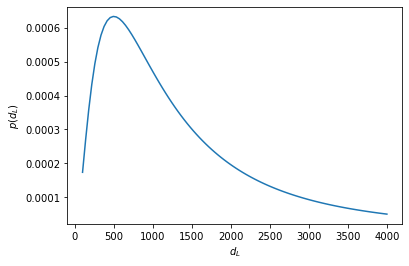

In [113]:
x = np.linspace(100,4000,100)
plt.plot(x, pdf(x, 500, 100, 4000))
plt.xlabel('$d_L$')
plt.ylabel(r'$p(d_L)$')
plt.show()

## Cumulative distribution function

In [18]:
def cdf(d, dstar, dmin, dmax):
    return normalization(dstar, dmin, d) / normalization(dstar, dmin, dmax)

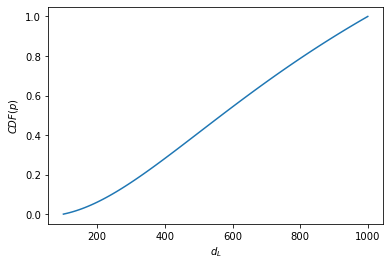

In [19]:
x = np.linspace(100,1000,100)
plt.plot(x, cdf(x, 500, 100, 1000))
plt.xlabel('$d_L$')
plt.ylabel(r'$CDF(p)$')
plt.show()

## Inverse CDF

### Subclassing `scipy.stats.rv_continuous`

This can compute the inverse CDF automatically. But it uses a numerical root-finding algorithm 

In [1]:
from scipy.stats import rv_continuous

In [14]:
class BWRadial(rv_continuous):
    
    def _cdf(self, x, dmin, dmax, dstar):
        return (((2*dmax + 3*dstar)**4*(-dmin + x)*
            (8*dmin**2*x**2*(dmin + x) + 18*dstar**3*(dmin**2 + dmin*x + x**2) + 
            8*dmin*dstar*x*(dmin**2 + 7*dmin*x + x**2) + 
           3*dstar**2*(dmin + x)*(dmin**2 + 16*dmin*x + x**2)))/
       ((dmax - dmin)*(8*dmax**2*dmin**2*(dmax + dmin) + 
           8*dmax*dmin*(dmax**2 + 7*dmax*dmin + dmin**2)*dstar + 
           3*(dmax + dmin)*(dmax**2 + 16*dmax*dmin + dmin**2)*dstar**2 + 
           18*(dmax**2 + dmax*dmin + dmin**2)*dstar**3)*(3*dstar + 2*x)**4))
        

In [15]:
dist = BWRadial(a=100,b=1000)

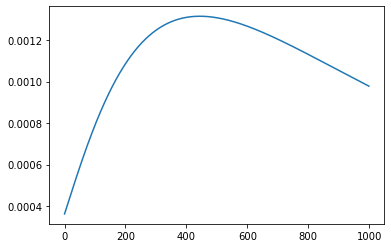

In [16]:
plt.plot(dist.pdf(np.linspace(100,1000,1000), 100, 1000, 500))

In [22]:
u = np.random.random(10000)

In [29]:
samp = dist.ppf(u, 100, 1000, 500)

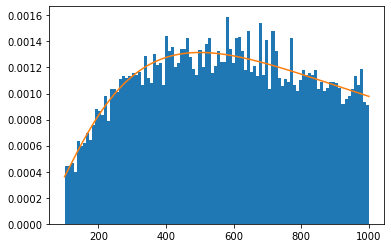

In [28]:
plt.hist(samp, density=True, bins=100)
plt.plot(np.linspace(100,1000,1000), dist.pdf(np.linspace(100,1000,1000), 100, 1000, 500))
plt.show()

### Analytic inverse CDF

Performing the integral for the CDF,
\begin{eqnarray}
u &=& \mathrm{CDF}(p)(d_L) = \int_{d_{L_,\min}}^{d_L} p(r) dr \\
&=& \frac{1}{N} \int_{d_{L_,\min}}^{d_L} \frac{r^2}{(2r/(3d_{L\ast}) + 1)^5} dr \\
&=& \frac{1}{N} \left( \frac{3d_{L\ast}}{2} \right)^3 \int_{y_\min}^y \frac{(y'-1)^2}{y'^5} dy',
\end{eqnarray}
where we made the change of variable $y' = 2r/(3d_{L\ast}) + 1$.

This can be done analytically, to obtain
$$
u = \left(\frac{3d_{L\ast}}{2}\right)^3\frac{1}{N} \left(f(y) - f(y_\min)\right),
$$
where
$$
f(y) = - \frac{1}{2y^2}+\frac{2}{3y^3}-\frac{1}{4y^4}.
$$

Rearranging,
$$
f(y) = f(y_\min) + \left(\frac{2}{3d_{L\ast}}\right)^3Nu \equiv A,
$$
so $y = f^{-1}(A)$. To invert $f$ requires one to solve a quartic equation,
$$
0 = y^4 + \frac{1}{2A}y^2 - \frac{2}{3A}y + \frac{1}{4A}.
$$
Fortunately, this is already in depressed quartic form, and we can solve this using Ferrari's method.

#### Solve the quartic

The quartic equation may be rearranged, introducing a new parameter $\alpha$, to obtain,
$$
0 = \left(y^2 + \frac{1}{4A} + \alpha\right)^2 - \left[ 2\alpha y^2 + \frac{2}{3A}y + \left(\alpha^2 + \frac{\alpha}{2A} + \frac{1}{16A^2} - \frac{1}{4A} \right)\right]
$$
We must choose $\alpha$ so that the square bracket reduces to a perfect square, like the first term. This happens if it has vanishing discriminant, i.e.,
$$
0 = \frac{4}{9A^2} - 8\alpha\left(\alpha^2 + \frac{\alpha}{2A} + \frac{1}{16A^2} - \frac{1}{4A}\right).
$$
This is a cubic equation for $\alpha$. We solve for its real root $\alpha_0$.

In [20]:
# With Mathematica, we determined the expression for \alpha_0 that is real over the relevant domain.

def alpha0(A):
    return (-(-2 + 4*np.sqrt(3)*np.sqrt(-A) + 
         A**2*(((-1 + 2*np.sqrt(3)*np.sqrt(-A))*(1 + 12*A))/A**3)**(2/3) + 
         ((1 + 12*A)*(-1 + 4*np.sqrt(3)*np.sqrt(-A) + 12*A)**2)**(1/3))/
      (12.*(-1 + 2*np.sqrt(3)*np.sqrt(-A))*A))

In [75]:
def should_be_zero(A):
    a0 = alpha0(A)
    return 4/(9*A**2) - 8*a0*(a0**2 + a0/(2*A) + 1/(16*A**2)- 1/(4*A))

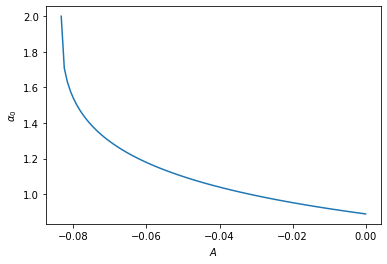

In [22]:
x = np.linspace(-1/12,-0.00001,100)
plt.plot(x, alpha0(x))
plt.xlabel('$A$')
plt.ylabel(r'$\alpha_0$')
plt.show()

To complete the solution of the quartic, we need to solve only quadratic equations. The quartic reduces to
$$
\left(y^2 + \frac{1}{4A} + \alpha_0\right)^2 = 2\alpha_0\left(y + \frac{1}{6\alpha_0A}\right)^2.
$$
Taking the square root,
$$
y^2 + \frac{1}{4A} + \alpha_0 =  \pm \sqrt{2\alpha_0}\left(y + \frac{1}{6\alpha_0A}\right).
$$
The relevant sign is $-$, and the equation reduces to
$$
y^2 + \sqrt{2\alpha_0} y + \left( \frac{1}{4A} + \alpha_0 + \frac{1}{3A\sqrt{2\alpha_0}}\right) = 0.
$$
And this has as relevant solution,
$$
y_0 = - \frac{\alpha_0}{\sqrt{2}} + \frac{1}{2}\sqrt{-\frac{1}{A} - 2\alpha_0 - \frac{4}{3\sqrt{2\alpha_0}A}}.
$$

In [101]:
def y0(A):
    a0 = alpha0(A)
    return  - np.sqrt(a0) / np.sqrt(2) + (1/2) * np.sqrt(-1/A - 2*a0 - (2/(3*A))*np.sqrt(2/a0))

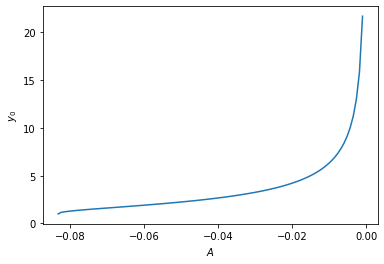

In [102]:
x = np.linspace(-1/12,-0.001,100)
plt.plot(x, y0(x))
plt.xlabel('$A$')
plt.ylabel(r'$y_0$')
plt.show()

#### Put it together

In [103]:
def f(y):
    return -1/(2*y**2) + 2/(3*y**3) - 1/(4*y**4)

def A(u, dstar, dmin, dmax):
    ymin = 2*dmin / (3*dstar) + 1
    n = normalization(dstar, dmin, dmax)
    return f(ymin) + (2/(3*dstar))**3*n*u 

def inverse_cdf(u, dstar, dmin, dmax):
    finv = y0(A(u, dstar, dmin, dmax))
    return 3*dstar/2 * (finv-1)

In [108]:
u = np.random.random(500000)
samples = inverse_cdf(u, 500, 100, 4000)

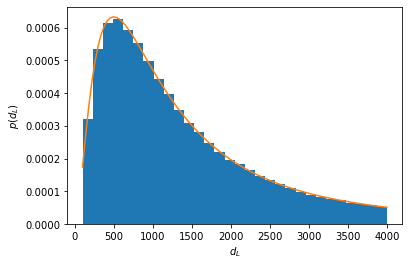

In [109]:
plt.hist(samples, bins=30, density=True)
x = np.linspace(100,4000,100)
plt.plot(x, pdf(x, 500, 100, 4000))
plt.xlabel('$d_L$')
plt.ylabel('$p(d_L)$')
plt.show()

This works, and is clearly much faster than numerical root-finding.